In [7]:
run run_residuals -vx -i FE_H -u -0.1 -d -0.105 -s red_clump -c False


Initialization runtime 0.85 s
Number of stars 194

Maximum SNR before correction 219.82
SNR correction runtime 0.04 s
Maximum SNR before correction 200.00

Nonzero Minimum SNR before mask 0.0012
SNR cut runtime 0.07 s
Minimum SNR after mask 50.0025

Bitmask application runtime 0.13 s

Pixel residuals runtime 0.45 s
Maximum residual 0.201419736421 

Finding random sigma runtime 1.15 s



In [8]:
hidefigs = False
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


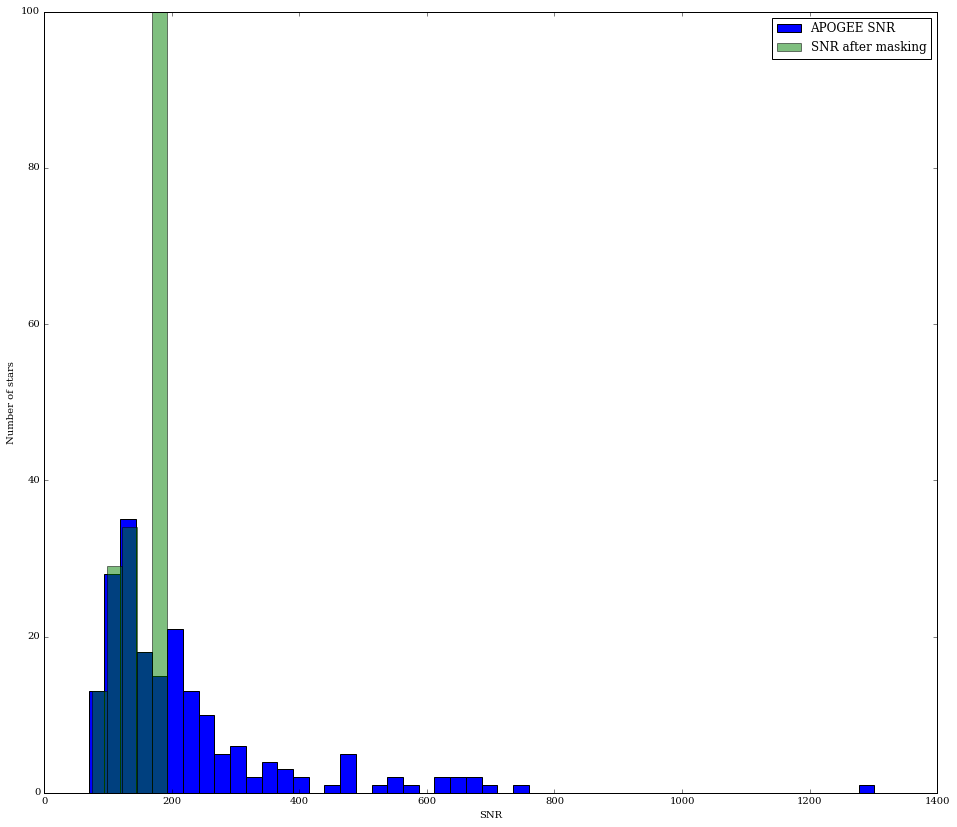

In [9]:
maSNR = np.ma.mean(starsample.specs/starsample.errs,axis=1)
# Plot SNR histogram

SNRhist,SNRbins = np.histogram(starsample.data['SNR'],bins = 50)
maSNRhist,maSNRbins = np.histogram(maSNR,bins=5)
plt.figure(figsize=(16,14))
plt.bar(SNRbins[:-1],SNRhist,width = (SNRbins[1]-SNRbins[0]),label='APOGEE SNR')
plt.bar(maSNRbins[:-1],maSNRhist,width = (maSNRbins[1]-maSNRbins[0]),color='green',alpha=0.5,label='SNR after masking')
plt.xlabel('SNR')
plt.ylabel('Number of stars')
plt.legend(loc = 'best')

In [11]:
# Do EMPCA
nvecs = 5
empcaname = starsample.outName('pkl',content = 'empca',order = starsample.order,seed = starsample.seed,cross=starsample.cross)
empcaname = empcaname.split('pkl')[0]+'nvec{0}'.format(nvecs)+'.pkl'
if os.path.isfile(empcaname):
    empcamodel,empcamodel_weight = acs.pklread(empcaname)
elif not os.path.isfile(empcaname):
    mask = (starsample.residual.mask.T==False)
    weights = mask.astype(int)
    weights[mask] = 1./starsample.errs[mask]**2 # Correct?
    empcamodel,runtime1 = timeIt(empca,starsample.residual.T,weights = mask.astype(int),nvec=nvecs)
    print 'Runtime:', runtime1/60.,' min'
    empcamodel_weight,runtime2 = timeIt(empca,starsample.residual.T,weights = weights,nvec=nvecs)
    print 'Runtime:', runtime2/60.,' min'
    acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])

       iter        R2             rchi2
EMPCA  1/25       0.01407524      0.00012084
EMPCA  2/25       0.15076617      0.00010406
EMPCA  3/25       0.17667434      0.00010088
EMPCA  4/25       0.19114942      0.00009911
EMPCA  5/25       0.20101114      0.00009790
EMPCA  6/25       0.20587412      0.00009730
EMPCA  7/25       0.20821345      0.00009702
EMPCA  8/25       0.20967309      0.00009684
EMPCA  9/25       0.21064462      0.00009672
EMPCA 10/25       0.21125001      0.00009665
EMPCA 11/25       0.21172659      0.00009659
EMPCA 12/25       0.21228324      0.00009652
EMPCA 13/25       0.21289990      0.00009644
EMPCA 14/25       0.21343319      0.00009638
EMPCA 15/25       0.21381020      0.00009633
EMPCA 16/25       0.21404657      0.00009630
EMPCA 17/25       0.21418442      0.00009629
EMPCA 18/25       0.21425902      0.00009628
EMPCA 19/25       0.21429423      0.00009627
EMPCA 20/25       0.21430582      0.00009627
EMPCA 21/25       0.21430445      0.00009627
EMPCA 22/25    

In [ ]:
Vnoise = (1./(starsample.numstars*aspcappix))*np.ma.sum(np.ma.sum(starsample.errs**2,axis=1))
R2noise = 1 - Vnoise/np.ma.var(starsample.residual.T)
R2 = np.zeros(nvecs)
R2_w = np.zeros(nvecs)
for vec in range(nvecs):
    R2[vec] = empcamodel.R2(vec)
    R2_w[vec] = empcamodel_weight.R2(vec)

In [ ]:
plt.figure(1)
plt.plot(range(nvecs),R2,label='Unweighted EMPCA')
plt.plot(range(nvecs),R2_w,label='Weighted EMPCA')
plt.axhline(R2noise,color='red',label='Noise Threshold')
plt.xlabel('Number of eigenvectors')
plt.ylabel('Variance')
plt.legend(loc='best')
plt.xlim(0,nvecs-1)
plt.savefig('./{0}/empcaR2_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}_nvec{7}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low,nvecs))
if hidefigs:
    plt.close()

In [ ]:
neweigvecs = np.zeros((nvecs,len(elems)))
neweigvecs_w = np.zeros((nvecs,len(elems)))
for ind in range(len(elems)):
    for vec in range(nvecs):
        neweigvecs[vec][ind] = starsample.weighting(empcamodel.eigvec[vec],elems[ind])
        neweigvecs_w[vec][ind] = starsample.weighting(empcamodel_weight.eigvec[vec],elems[ind])

In [ ]:
# Create weighted residuals
weighted = np.ma.masked_array(np.zeros((len(elems),len(starsample.specs))))
weightedsigs = np.ma.masked_array(np.zeros((len(elems),len(starsample.specs))))
i=0
for elem in elems:
    weightedr = starsample.weighting_stars(starsample.residual,elem,
                                           starsample.outName('pkl','resids',elem=elem,
                                                              order = starsample.order,cross=starsample.cross))
    weighteds = starsample.weighting_stars(starsample.sigma,elem,
                                           starsample.outName('pkl','sigma',elem=elem,
                                                              order = starsample.order,seed = starsample.seed))
    doubleResidualHistPlot(elem,weightedr,weighteds,
                           starsample.outName('res','residhist',elem = elem,order = starsample.order,
                                              cross=starsample.cross,seed = starsample.seed),
                           bins = 50)
    weighted[i] = weightedr
    weightedsigs[i] = weighteds
    i+=1

In [ ]:
# Do EMPCA on weighted residuals
nvecs = 5
empcaname = starsample.outName('pkl',content = 'empca_element',order = starsample.order,
                               seed = starsample.seed,cross=starsample.cross)
empcaname = empcaname.split('pkl')[0]+'nvec{0}'.format(nvecs)+'.pkl'
if os.path.isfile(empcaname):
    empcamodel,empcamodel_weight = acs.pklread(empcaname)
elif not os.path.isfile(empcaname):
    mask = (weighted.mask==False)
    weights = mask.astype(int)
    weights[mask] = 1./testsample.sigma # Correct?
    wempcamodel,runtime1 = timeIt(empca,weighted,weights = mask.astype(int),nvec=nvecs)
    print 'Runtime:', runtime1/60.,' min'
    wempcamodel_weight,runtime2 = timeIt(empca,weighted,weights = weights,nvec=nvecs)
    print 'Runtime:', runtime2/60.,' min'
    acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])

In [ ]:
for vec in range(5):
    plt.figure(figsize=(16,14))
    plt.xticks(range(len(elems)),elems)
    plt.plot(neweigvecs[vec],label='Unweighted EMPCA - raw')
    plt.plot(neweigvecs_w[vec],label='Weighted EMPCA - raw')
    plt.plot(wempcapmodel.eigvec[vec],label = 'Unweighted EMPCA - proc')
    plt.plot(wempcamodel_weight.eigvec[vec] = 'Weighted EMPCA - proc')
    plt.legend(loc='best')
    plt.xlabel('Elements')
    plt.ylabel('Eigenvector')
    plt.title('{0} eigenvector, weighted by element'.format(vec))
    plt.savefig('./{0}/empcaeig{1}_order{2}_seed{3}_cross{4}_{5}_u{6}_d{7}_nvec{8}.png'.format(starsample.type,vec, starsample.order,starsample.seed,starsample.cross,label,up,low,nvecs))
    if hidefigs:
        plt.close()

In [ ]:
plt.figure()
allmasksplot = np.copy(starsample.mask.astype(np.float64))
allmasksplot[np.where(starsample.mask==0)] = np.nan
plt.imshow(allmasksplot,aspect = 7214./starsample.numstars,interpolation='nearest',cmap = 'viridis')
plt.ylim(0,starsample.numstars)
plt.colorbar()
plt.savefig('./{0}/test2_mask_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

plt.figure()
allbitmasksplot = np.copy(starsample.bitmask).astype(np.float64)
allbitmasksplot[np.where(starsample.bitmask==0)] = np.nan
plt.imshow(np.log2(allbitmasksplot),aspect = 7214./starsample.numstars,interpolation='nearest',cmap = 'viridis')
plt.ylim(0,starsample.numstars)
plt.colorbar()
plt.savefig('./{0}/test2_bitmask_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

plt.figure()
SNRplot = starsample.specs/starsample.errs
SNRplot[np.where(SNRplot.mask!=0)] = np.nan
plt.imshow(SNRplot,aspect = 7214./starsample.numstars,interpolation='nearest',cmap = 'viridis')
plt.ylim(0,starsample.numstars)
plt.colorbar()
plt.savefig('./{0}/test2_SNR_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

In [ ]:
residcov = np.ma.cov(starsample.residual)
normresidcov = np.ma.cov(starsample.residual/starsample.errs.T)

In [ ]:
rcovlim = 1e-4
nrcovlim = 4

In [ ]:
# Plot covariance of raw pixel residuals
plt.figure(figsize=(10,12))
plt.imshow(residcov,interpolation='nearest',cmap = 'Spectral',vmax=rcovlim,vmin=-rcovlim)
plt.colorbar()
plt.savefig('./{0}/covariance_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

# Plot covariance of residuals divided by pixel flux uncertainty
plt.figure(figsize=(10,12))
plt.imshow(normresidcov,interpolation='nearest',cmap = 'Spectral',vmax=nrcovlim,vmin=-nrcovlim)
plt.colorbar()
plt.savefig('./{0}/normcovariance_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

# Plot diagonal of covariance of raw pixel residuals
plt.figure(figsize=(16,4))
diag = np.array([residcov[i,i] for i in range(len(residcov))])
plt.plot(diag)
plt.xlim(0,len(diag))
plt.xlabel('Pixel')
plt.ylabel('Variance')
plt.savefig('./{0}/covariance_diag_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

# Plot diagonal of  covariance of residuals divided by pixel flux uncertainty
plt.figure(figsize=(16,4))
normdiag = np.array([normresidcov[i,i] for i in range(len(normresidcov))])
plt.plot(normdiag,linewidth = 0.5)
plt.xlim(0,len(normdiag))
plt.ylim(0,10)
plt.xlabel('Pixel')
plt.ylabel('Variance')
plt.savefig('./{0}/normcovariance_diag_order{1}_seed{2}_cross{3}_{4}_u{5}_d{6}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

# Plot two slices of the covariance matrices
samppix = 3700
plt.figure(figsize=(16,8))
plt.plot(residcov[samppix]/np.max(residcov[samppix]),label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
plt.plot(normresidcov[samppix]/np.max(normresidcov[samppix]),label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
plt.axvline(samppix,color='red')
plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
plt.xlabel('Pixel')
plt.xlim(samppix-100,samppix+100)
plt.legend(loc = 'best')
plt.savefig('./{0}/covariancepix{1}_order{2}_seed{3}_cross{4}_{5}_u{6}_d{7}.png'.format(starsample.type, samppix,starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()

samppix = 6000
plt.figure(figsize=(16,8))
plt.plot(residcov[samppix]/np.max(residcov[samppix]),label = 'Raw residual, peak = {0}'.format(np.max(residcov[samppix])))
plt.plot(normresidcov[samppix]/np.max(normresidcov[samppix]),label = 'Sigma normalized residual, peak = {0}'.format(np.max(normresidcov[samppix])))
plt.axvline(samppix,color='red')
plt.ylabel('Covariance at pixel {0} normalized to peak'.format(samppix))
plt.xlabel('Pixel')
plt.xlim(samppix-100,samppix+100)
plt.legend(loc = 'best')
plt.savefig('./{0}/covariancepix{1}_order{2}_seed{3}_cross{4}_{5}_u{6}_d{7}.png'.format(starsample.type, samppix,starsample.order,starsample.seed,starsample.cross,label,up,low))
if hidefigs:
    plt.close()